Импорт основных библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import BytesIO

Считываем все нужные таблицы через ссылку

In [2]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df = pd.read_excel(BytesIO(response.content), engine='openpyxl')

Сортируем датасет

In [3]:
df = df.sort_values(by='dt').reset_index(drop=True)
df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


Размер Датасета

In [4]:
df.shape

(400, 2)

нулевых значений нет

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


# Проверка на стационарность, авторкорреляцию

Судя по графику, временной ряд случайный. Однако, можно предположить, что он все таки увеличивается. Чтобы не гадать, можно это проверить

<Axes: ylabel='Цена на арматуру'>

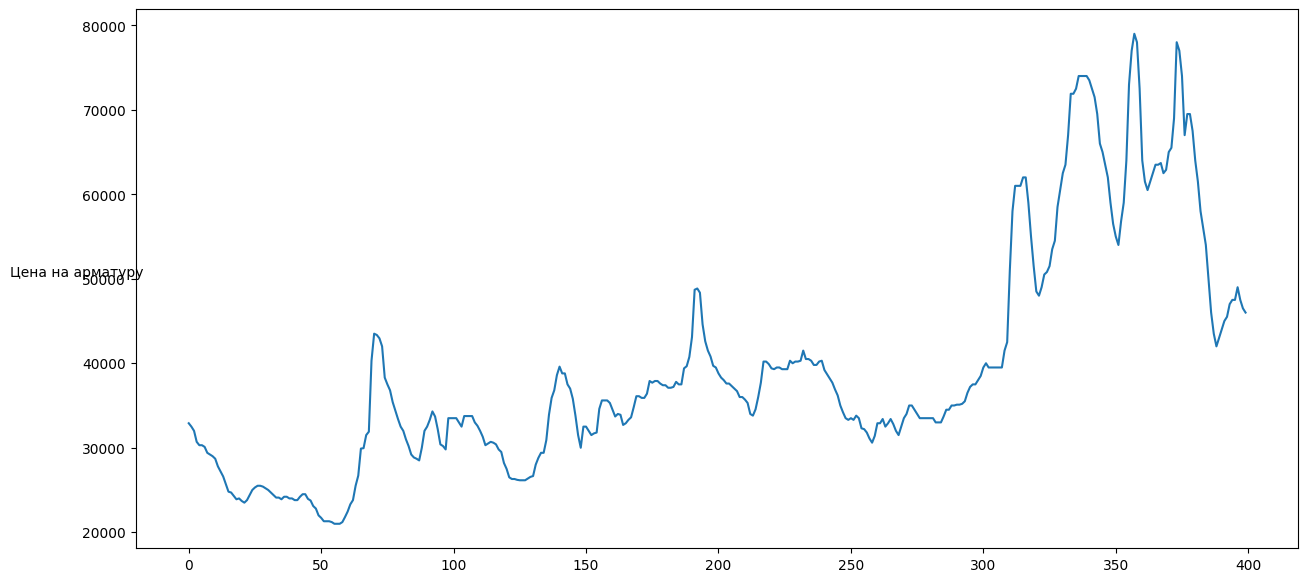

In [6]:
plt.figure(figsize=(15, 7))
plt.ylabel('Цена на арматуру', rotation=0)
df['Цена на арматуру'].plot()

In [7]:
!pip install statsmodels==0.14.4

Отсюда можем взять стат.характеристика как признаки для модели

In [8]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


Приводим дату к формату даты и делаем её индексом

In [9]:
df['dt'] = pd.to_datetime(df['dt'], format='%m-%d-%Y')

df = df.set_index(['dt'])

Разложение ряда на компоненты: тренд, сезоннотсь, шум, и оригинальные данные

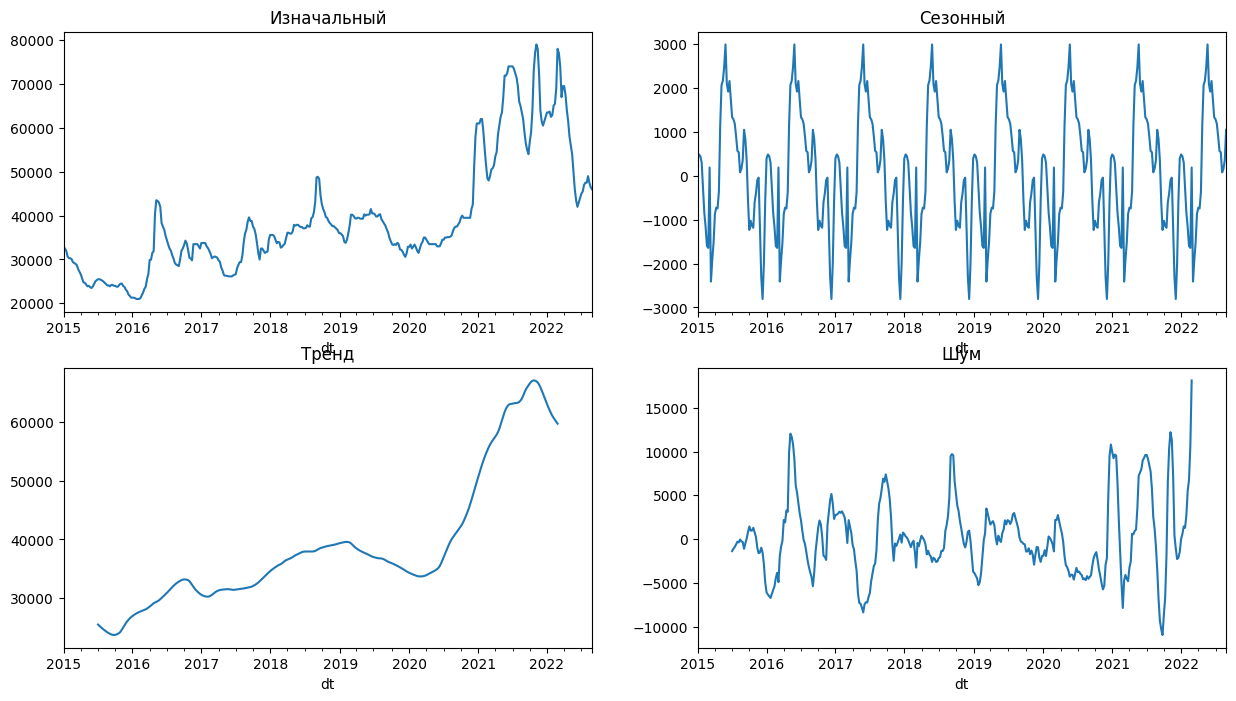

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0, 0].set_title('Изначальный')
ax[0, 1].set_title('Сезонный')
ax[1, 0].set_title('Тренд')
ax[1, 1].set_title('Шум')

decompose.observed.plot(ax=ax[0, 0])
decompose.seasonal.plot(ax=ax[0, 1])
decompose.trend.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1]);


Снова раскладываем на компоненты и сохраняем в датасет как признак

In [11]:
from statsmodels.tsa.seasonal import STL

values = np.sin(np.linspace(0, 40, 400)) * 10 + np.arange(400)
data = pd.Series(values, index=df['Цена на арматуру'])

decomposition = STL(df, seasonal=13).fit()
trend = decomposition.trend
seasonal = decomposition.seasonal
df['trend'] = trend
df['season'] = seasonal

**Тест на стационарность**

можно предположить, т.к. p > 0.05, что временной ряд нестационарен

In [12]:
from statsmodels.tsa.stattools import adfuller, acf

result = adfuller(df['Цена на арматуру'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155


**Автокорреляция и частичная автокорреляция**

Здесь мы можем увидеть важные лаги - те, которые не входят в закрашенную область

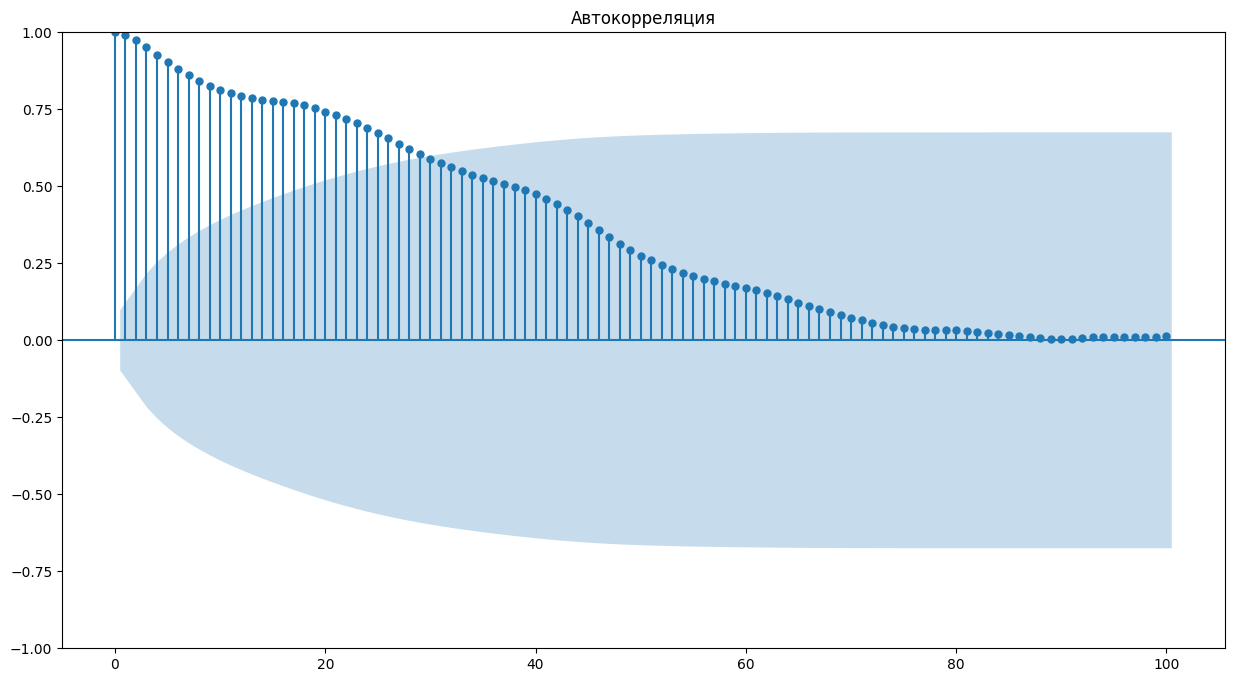

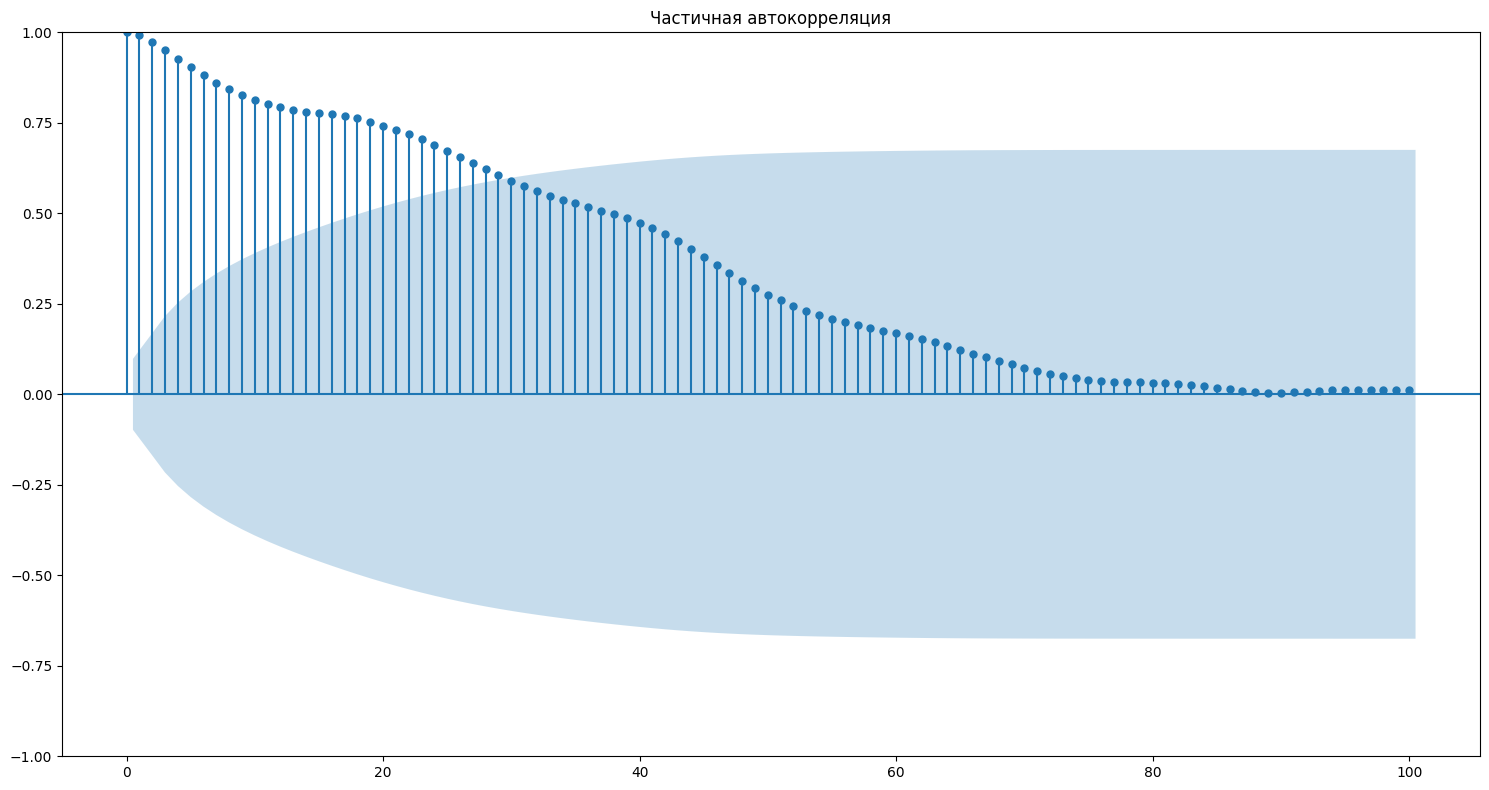

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15,8))
plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Автокорреляция')

plt.figure(figsize=(15,8))

plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

Основные 25 лагов не входят в закрашенный промежток, значит значение из этого диапазона можно использовать как признаки для модели

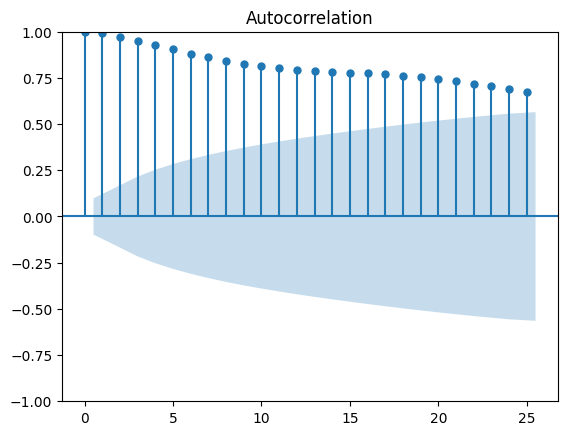

In [14]:
plot_acf(df['Цена на арматуру'], lags=25)
plt.show()

# Преобразование временного ряда в стационарный

Надо сделать стационарный временной ряд, и использовать его как признак при обучении модели


Сезонное дифференцирование, выбираем период 7

In [15]:
!pip install PyWavelets

Лаги


In [16]:
df['lag_1'] = df['Цена на арматуру'].shift(1)
df['lag_2'] = df['Цена на арматуру'].shift(2)
df['lag_3'] = df['Цена на арматуру'].shift(3)
df['lag_4'] = df['Цена на арматуру'].shift(4)
df['lag_52'] = df['Цена на арматуру'].shift(52)


Временные признаки

In [17]:
window = 7
df['rolling_mean'] = df['Цена на арматуру'].rolling(window=window).mean()
df['rolling_std'] = df['Цена на арматуру'].rolling(window=window).std()
df['rolling_min'] = df['Цена на арматуру'].rolling(window=window).min()
df['rolling_max'] = df['Цена на арматуру'].rolling(window=window).max()
df['rolling_range'] = df['rolling_max'] - df['rolling_min']

# # коэффициент вариации
df['coef_of_variation'] = df['rolling_std'] / df['rolling_mean']

# интерквартильный размах (пример для 25% и 75%)
df['rolling_25%'] = df['Цена на арматуру'].rolling(window=window).quantile(0.25)
df['rolling_75%'] = df['Цена на арматуру'].rolling(window=window).quantile(0.75)
df['rolling_iqr'] = df['rolling_75%'] - df['rolling_25%']

Делаем колонку без шума

In [18]:
import pywt

coeffs = pywt.dwt(df["Цена на арматуру"], 'db4')

# Восстанавливаем сигнал без деталей (шумоподавленный ряд)
df["denoised"] = pywt.idwt(coeffs[0], None, 'db4')

In [19]:
from scipy.ndimage import gaussian_filter1d
smoothed_series = gaussian_filter1d(df['Цена на арматуру'], sigma=2)
df['goosse'] = smoothed_series

In [20]:
df["ema"] = df["Цена на арматуру"].ewm(span=10, adjust=False).mean()

In [21]:
!pip install tensorflow

Заполняем пропуски в датасете, которые могли появиться после добавления лагов

In [22]:
df.fillna(method='ffill', inplace=True)  # Заполнить пропуски вперед
df.fillna(method='bfill', inplace=True)  # Заполнить пропуски назад


<ipython-input-22-474276ecf92a>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Заполнить пропуски вперед
<ipython-input-22-474276ecf92a>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Заполнить пропуски назад


**Корреляция признаков и целевой переменной**

Какие-то признаки сильно коррелируют между собой, скорее всего не все из них имеют смысл

<Axes: >

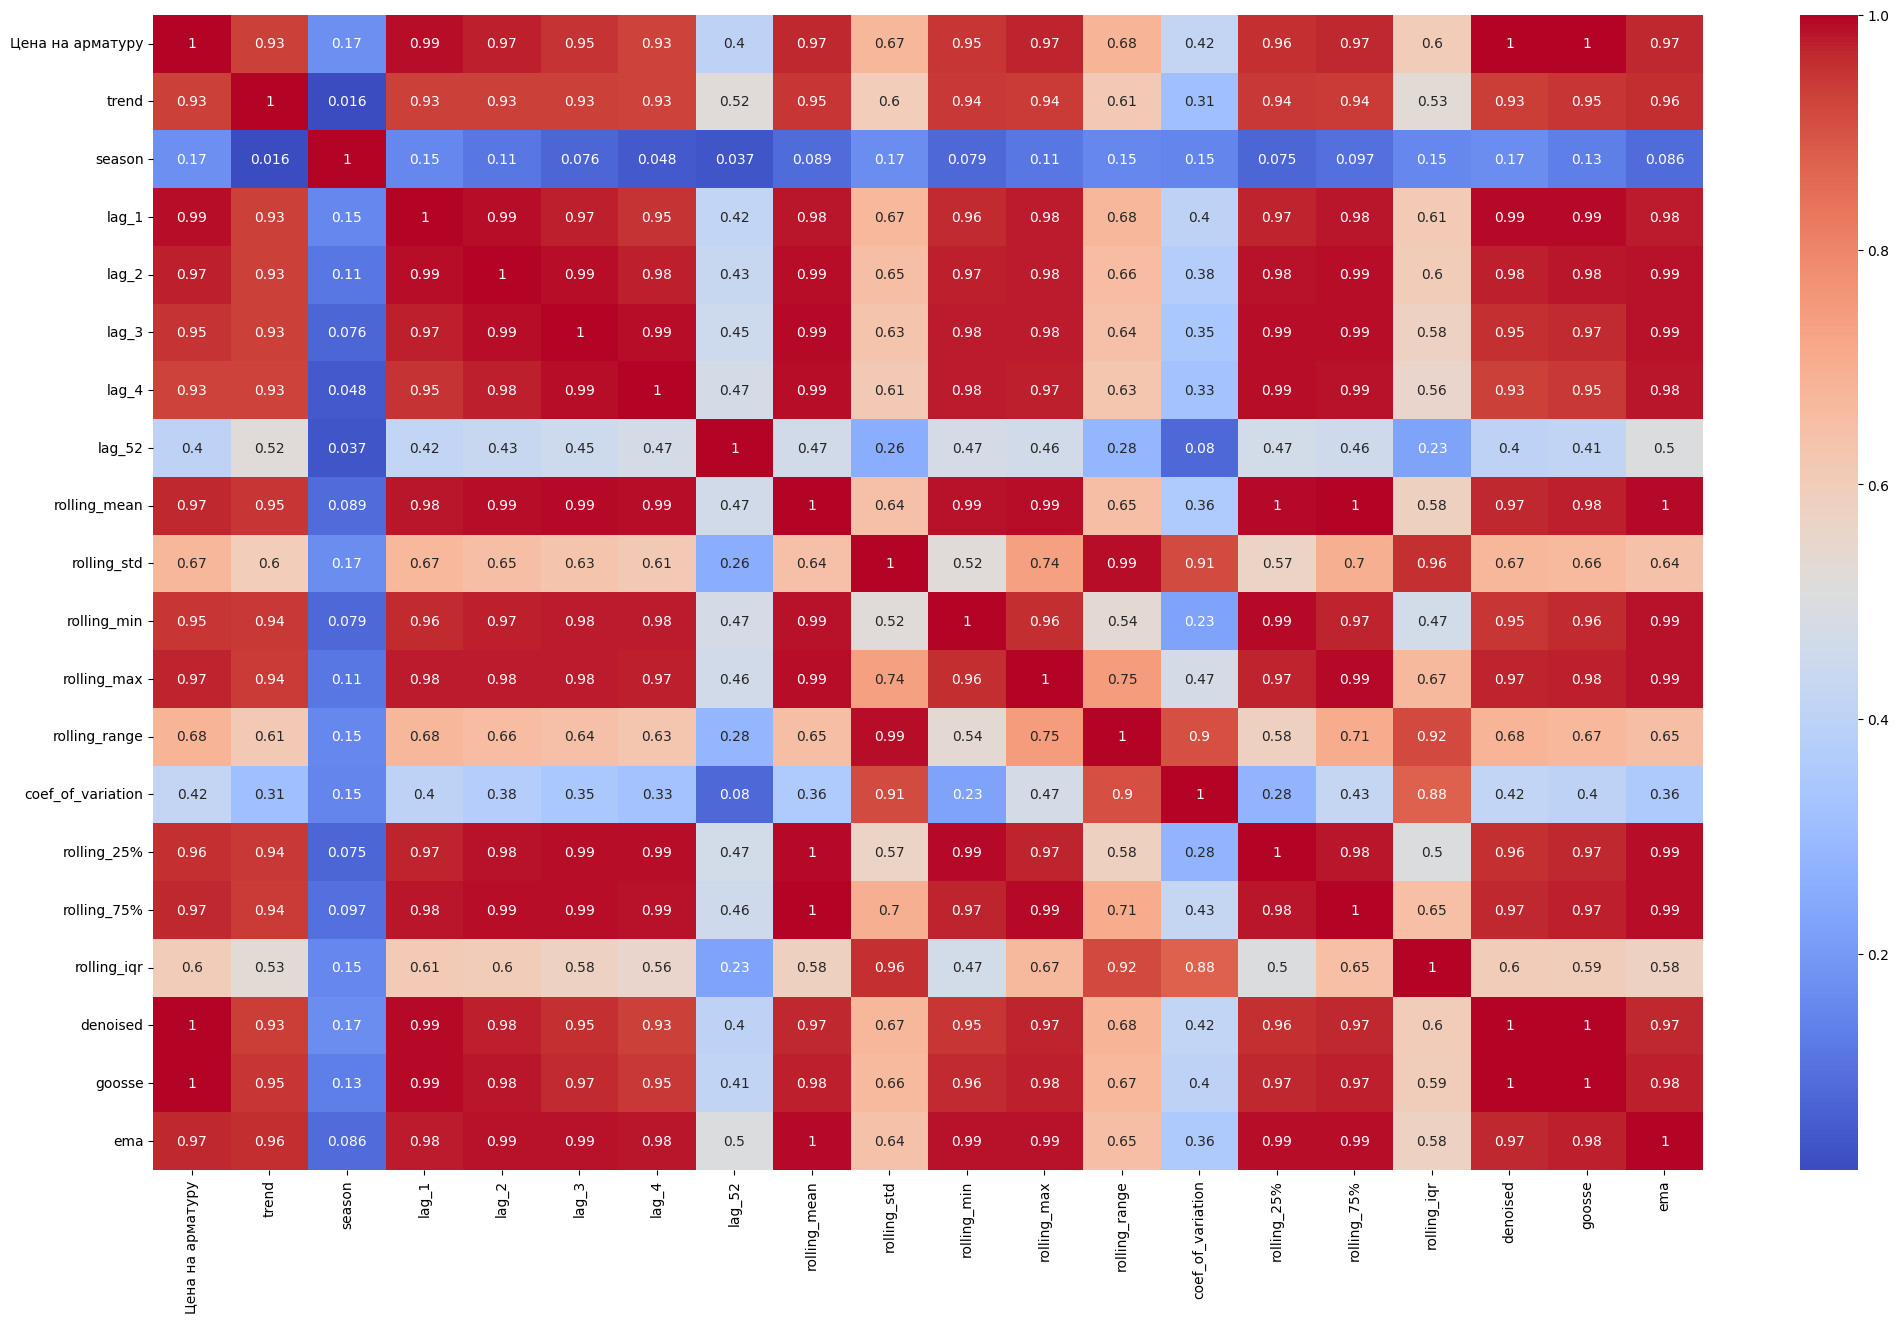

In [23]:
plt.figure(figsize=(25,15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

# Создаем модель LSTM

К сожалению, модель показывает не очень хорошие результаты

Хоть она и улавливает тренд и сезонность, но её предсказания недостаточно точные, и ошибаются на целых 3 тысячи рублей :(

*Хотя показатель R² равен 0.9444, что говорит о том, что модель в целом была бы не плохой, но возможно из-за того, что неправильно подобраны признаки (или их недостаточно), или параметры модели, или данных очень мало (всего 400 строчек), она работает не так хорошо как хотелось бы*

Вывод: лучше использовать другую модель

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 299ms/step - loss: 0.0500 - val_loss: 0.0602
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0127 - val_loss: 0.0359
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0066 - val_loss: 0.0178
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0055 - val_loss: 0.0274
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0049 - val_loss: 0.0177
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0045 - val_loss: 0.0166
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0043 - val_loss: 0.0157
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0029 - val_loss: 0.0137
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0021 - val_loss: 0.0146
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0027 - val_loss: 0.0121
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0024 - val_loss: 0.0161
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0023 - val

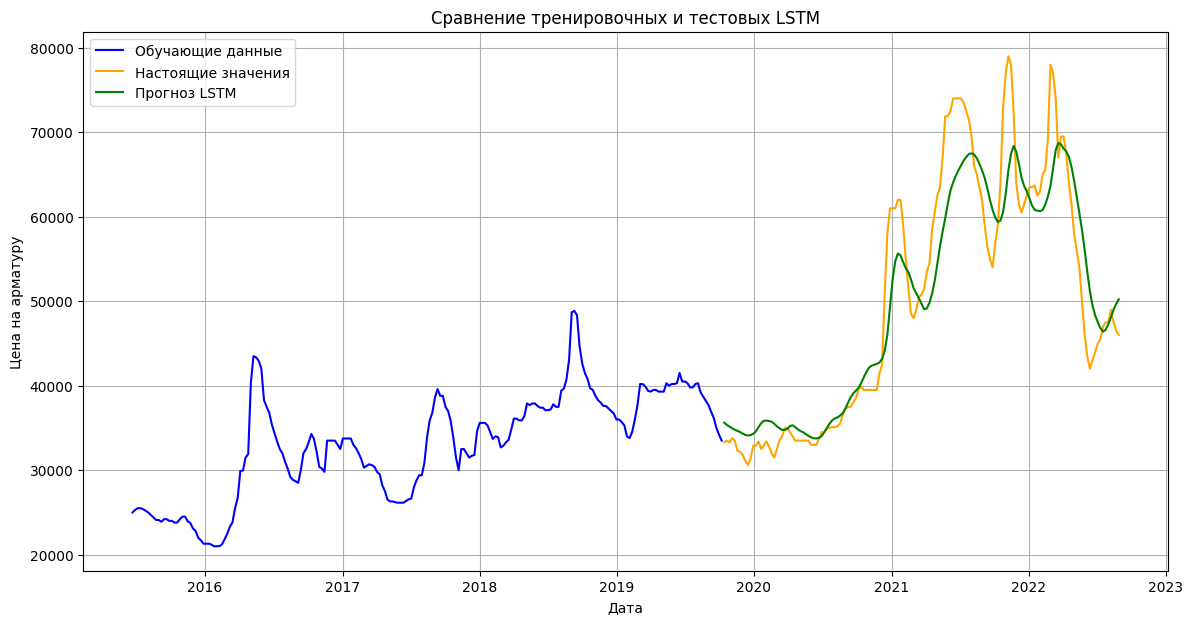

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import os
import random
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Bidirectional

# ограничиваем случайность предсказаний
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

df.index = pd.to_datetime(df.index)


target = df['Цена на арматуру'].values.reshape(-1, 1)
features = df.drop(columns=['Цена на арматуру']).values

# масштабирование, чтобы модель работала корректно
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))

target_scaled = scaler_target.fit_transform(target)
features_scaled = scaler_features.fit_transform(features)

# объединяем целевую переменную и дополнительные признаки
data_scaled = np.hstack((target_scaled, features_scaled))

# Функция для создания датасета с временными шагами
def create_dataset(data, timesteps=1):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:(i + timesteps), :])  # все признаки
        y.append(data[i + timesteps, 0])  # целевая переменная
    return np.array(X), np.array(y)

# параметры
timesteps = 24  # кол. временных шагов
X, y = create_dataset(data_scaled, timesteps)


train_size = int(len(X) * 0.6)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# преобразование данных в 3D-формат (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


model = Sequential()

# Добавляем сверточный слой перед LSTM
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(timesteps, X_train.shape[2])))

# LSTM слои
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dropout(0.3))

# Выходной слой
model.add(Dense(1))


# learning_rate = 0.005669387181782102
initial_learning_rate = 0.005669387181782102
lr_schedule = tensorflow.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=1000, alpha=0.0001)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
initial_learning_rate = 0.001
lr_schedule = tensorflow.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps=1000, alpha=0.0001
)

optimizer = Adam(learning_rate=lr_schedule)  # Создаем Adam с CosineDecay

model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])  # Без ReduceLROnPlateau

# ПРОГНОЗ
y_pred_scaled = model.predict(X_test)

# Обратное преобразование масштаба данных
y_pred = scaler_target.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# МЕТРИКИ
mse = mean_squared_error(y_test_original, y_pred)
rmse = mse ** 0.5
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, y_pred)
print(f'R²: {r2:.4f}')

# ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(14, 7))
plt.plot(df.index[timesteps:train_size + timesteps], scaler_target.inverse_transform(y_train.reshape(-1, 1)), label='Обучающие данные', color='blue')
plt.plot(df.index[train_size + timesteps:], y_test_original, label='Настоящие значения', color='orange')
plt.plot(df.index[train_size + timesteps:], y_pred, label='Прогноз LSTM', color='green')
plt.xlabel('Дата')
plt.ylabel('Цена на арматуру')
plt.title('Сравнение тренировочных и тестовых LSTM')
plt.legend()
plt.grid()
plt.show()

Прогноз LSTM

In [25]:
future_steps = 6
last_sequence = X_test[-1].copy()  # Берем последнюю известную последовательность
forecast = []

for _ in range(future_steps):
    # Делаем прогноз
    next_pred_scaled = model.predict(last_sequence.reshape(1, timesteps, X_train.shape[2]), verbose=0)
    next_pred = scaler_target.inverse_transform(next_pred_scaled)[0, 0]

    # Ограничение, чтобы не было отрицательных значений
    next_pred = max(0, next_pred)
    forecast.append(next_pred)

    # Обновляем входную последовательность
    last_sequence = np.roll(last_sequence, shift=-1, axis=0)  # Сдвигаем влево

    # Вставляем предсказанное значение (убедитесь, что это правильный индекс признака)
    last_sequence[-1, 0] = next_pred_scaled[0, 0]  # Предполагая, что целевая переменная в 0 индексе

# Генерируем индексы дат (убедитесь, что df.index имеет частоту 'W-MON')
forecast_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(weeks=1), periods=future_steps, freq='W-MON')



In [26]:
forecast = [float(x) for x in forecast]

Прогноз LSTM

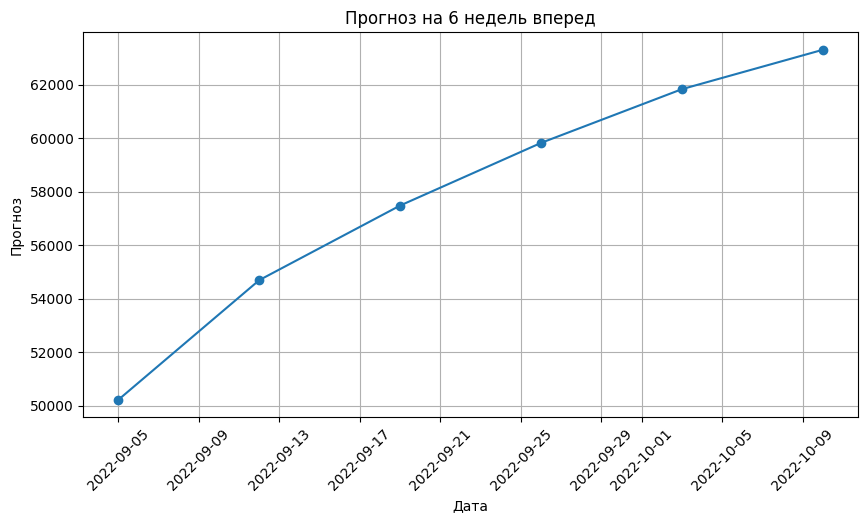

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_dates, forecast, marker='o', linestyle='-')
plt.xlabel("Дата")
plt.ylabel("Прогноз")
plt.title("Прогноз на 6 недель вперед")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Сохраняем предсказания в таблицу

In [28]:
lstm_forecast = model.predict(X_test)

# новый df с датами и предсказаниями
lstm_predictions = pd.DataFrame({
    "dt": df.index[train_size + timesteps:],  # даты
    "LSTM_Pred": y_pred.flatten()
})

# csv файл
lstm_predictions.to_csv("lstm_predictions.csv", index=False)
print("Файл lstm_predictions.csv сохранен!")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Файл lstm_predictions.csv сохранен!


Сохраняем модель LSTM с её параметрами

In [29]:
import pickle
from tensorflow.keras.models import save_model


save_model(model, 'armature_price_model.h5')


with open('model.pkl', 'wb') as f:
    pickle.dump(scaler_target, f)


# Модель SARIMA

Будет обучать SARIMA на логарифмированном значении

In [30]:
df['price_log'] = np.log(df['Цена на арматуру'])

В отличие от LSTM здесь модель обучается на всем датасете


Используем параметры SARIMA: p=1, d=1, q=1, P=1, D=1, Q=1, m=52


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


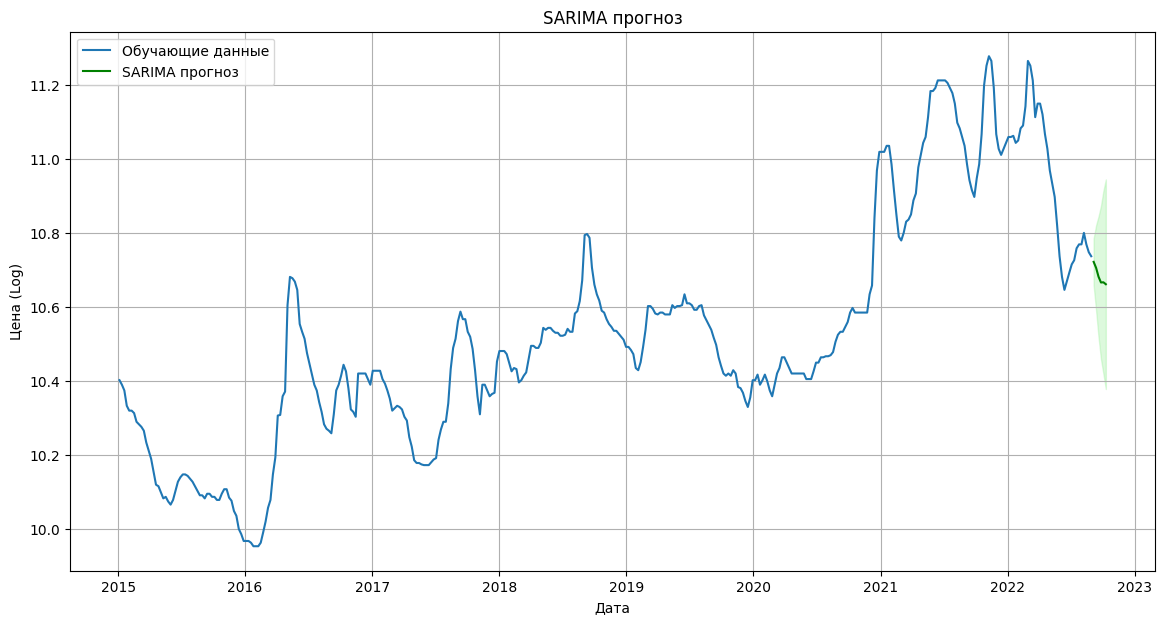

In [31]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 1, 1, 1  # Для автокорреляции
P, D, Q, m = 1, 1, 1, 52  # m = 52 — сезонность по годам

print(f"\nИспользуем параметры SARIMA: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, m={m}")

sarima_model = SARIMAX(df['price_log'].dropna(),  # Целевая переменная
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, m))
sarima_result = sarima_model.fit()

# Прогноз SARIMA
sarima_forecast = sarima_result.get_forecast(steps=6)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Визуализация прогноза SARIMA
plt.figure(figsize=(14, 7))
plt.plot(df['price_log'], label='Обучающие данные')
plt.plot(sarima_pred, label='SARIMA прогноз', color='green')
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA прогноз')
plt.xlabel('Дата')
plt.ylabel('Цена (Log)')
plt.legend()
plt.grid()
plt.show()

In [32]:
!pip install dill

Функция для подсчета количества объема недель

In [33]:
def predict_N_weeks(date, current_price, model, steps=6):
    try: # если дата из будущего
        forecast_result = sarima_result.get_prediction(start=date, end=date+pd.DateOffset(weeks=steps))
    except:
        forecast_result = sarima_result.get_forecast(steps=steps) # если начинается с последней даты

    forecasted_value = np.exp(forecast_result.predicted_mean) # преобразуем в нормальные цены обратно

    price_increase = (forecasted_value > current_price)  # True False

    if price_increase.all(): # цена растет постоянно
        return 6
    if not price_increase.any():  # цена вообще не растет
        return 1

    else:
        return np.argmax(price_increase == False) + 1 # берем максимум недель на которые цена растет

Загружаем модель SARIMA вместе с функцией

In [34]:
import dill

with open('sarima_model.pkl', 'wb') as f:
  dill.dump({
    'model': sarima_result,
    'predict_N' : predict_N_weeks
  }, f)